# Germany Rental Prediction - Creating Model

## Contents:
- Part 1: Cleaning and Visualization
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1biEgivJEOUVS8KbeTXyb1lNgsVtbitYj)

- Part 2: Using PyCaret for Model Hyperparameters Tuning
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lXJhdH3rGnKQ_LjBGMh8ZK-Lf2VcfLW5)
- Part 3: Create Model
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14XIC90Lss_izdw-PE1cgIe4eECsXrHbY)


## Purpose from this notebook.

Creating the model base on '02_model_comparison_pycaret.ipynb' which has already done all the hyperparameters tuning by using PyCaret.

We will create 2 models which are
1. Ridge Regression: [Wikipedia](https://en.wikipedia.org/wiki/Ridge_regression#:~:text=Ridge%20regression%20is%20a%20method,econometrics%2C%20chemistry%2C%20and%20engineering.)
2. Light Gradient Boostt: [Wikipedia](https://en.wikipedia.org/wiki/LightGBM)
3. Extreme Gradient Boost
4. CatBoost
5. Linear Regression

and compare it by using the metrics such as R2 ([Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)) and RMSE ([Root Mean Square Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) which is the standard matrix to measure the accuracy of the regression model. In addition, we will compare the speed of comparison to which model is much faster when you're using it as a prediction.

# Basic data handling and inspection

Import all important libraries in this kernel

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

Load the dataset to the kernel

In [11]:
!gdown --id 1yw4RN-Z9b7PlF45kC5HnXZokaXivk3EV

df = pd.read_csv('predict_test.csv').iloc[:,1:]
df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yw4RN-Z9b7PlF45kC5HnXZokaXivk3EV
To: /Users/mac_os/Desktop/DTSENSE/final_project/predict_test.csv
100%|██████████████████████████████████████| 15.0M/15.0M [00:01<00:00, 9.31MB/s]


,heatingType,totalRent,livingSpace,condition,typeOfFlat,noRooms,regio2,rent_difference,additioncost
0,central_heating,840.00,86.00,well_kept,ground_floor,4.0,Dortmund,245.0,245.0
1,self_contained_central_heating,903.00,84.97,refurbished,apartment,3.0,Bremen,138.0,138.0
2,self_contained_central_heating,380.00,62.00,fully_renovated,apartment,2.0,Mittelsachsen,70.0,70.0
3,central_heating,584.25,60.30,Other,ground_floor,3.0,Bremen,132.0,132.0
4,oil_heating,690.00,53.00,well_kept,roof_storey,2.0,Other,110.0,110.0


In [12]:
df[df['regio2']=='Berlin']

,heatingType,totalRent,livingSpace,condition,typeOfFlat,noRooms,regio2,rent_difference,additioncost
22,central_heating,1140.00,77.00,Other,ground_floor,3.0,Berlin,320.00,320.00
33,central_heating,955.00,62.63,refurbished,ground_floor,2.0,Berlin,147.00,147.00
50,floor_heating,1428.78,67.00,mint_condition,apartment,2.5,Berlin,228.78,228.78
51,district_heating,1559.05,73.54,first_time_use,ground_floor,2.0,Berlin,220.62,220.62
76,combined_heat_and_power_plant,1280.00,83.14,mint_condition,apartment,3.0,Berlin,232.00,232.00
...,...,...,...,...,...,...,...,...,...
178190,central_heating,945.00,93.47,well_kept,apartment,4.0,Berlin,195.00,195.00
178234,central_heating,1250.00,85.00,well_kept,apartment,3.0,Berlin,250.00,250.00
178237,central_heating,630.00,57.00,well_kept,roof_storey,1.0,Berlin,155.00,155.00
178251,self_contained_central_heating,850.00,59.82,well_kept,apartment,2.0,Berlin,100.00,100.00


# Machine Learning

If it's an object or bool type (True,False). The code below will create the dummies for all of the categorical.

In [13]:
# Create dummy variables
columns = []
for cols in df.columns:
    if df[cols].dtype == 'object' or df[cols].dtype == 'bool':
        columns.append(cols)
dummies_feature = pd.get_dummies(df[columns],prefix='',prefix_sep='')
dummies_feature.head()

,central_heating,combined_heat_and_power_plant,district_heating,floor_heating,gas_heating,heat_pump,night_storage_heater,oil_heating,self_contained_central_heating,wood_pellet_heating,Other,first_time_use,first_time_use_after_refurbishment,fully_renovated,mint_condition,modernized,refurbished,well_kept,apartment,ground_floor,half_basement,loft,maisonette,other,penthouse,raised_ground_floor,roof_storey,terraced_flat,Aachen,Anhalt_Bitterfeld,Augsburg,Bautzen,Berlin,Bielefeld,Bochum,Bonn,Braunschweig,Bremen,Bremerhaven,Burgenlandkreis,Chemnitz,Cottbus,Dessau_Roßlau,Dortmund,Dresden,Duisburg,Düsseldorf,Ennepe_Ruhr,Erfurt,Erzgebirgskreis,Essen,Esslingen,Frankfurt_am_Main,Gelsenkirchen,Gera,Gießen,Görlitz,Hagen,Halle_Saale,Hamburg,Hannover,Harz,Heilbronn,Herne,Hochtaunuskreis,Karlsruhe,Kassel,Kiel,Krefeld,Köln,Leipzig,Lörrach,Magdeburg,Main_Kinzig,Main_Taunus,Mainz,Mannheim,Meißen,Mettmann,Mittelsachsen,Märkischer,Mönchengladbach,Mülheim_an_der_Ruhr,München,Neuss_Rhein,Nordsachsen,Nürnberg,Oberhausen,Offenbach,Other,Pinneberg,Plauen,Recklinghausen,Regensburg,Rhein_Erft,Rhein_Neckar,Rhein_Sieg,Rheinisch_Bergischer,Rostock,Saalekreis,Schwerin,Stuttgart,Sächsische_Schweiz_Osterzgebirge,Unna,Vogtlandkreis,Wesel,Wiesbaden,Wuppertal,Zwickau
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False

Combine those columns together and drop the categorical columns that we created for the dummies.

In [14]:
predict_df = df.copy()
predict_df = predict_df.drop(columns=columns)
predict_df = pd.concat([predict_df, dummies_feature], axis=1)
predict_df.head()

,totalRent,livingSpace,noRooms,rent_difference,additioncost,central_heating,combined_heat_and_power_plant,district_heating,floor_heating,gas_heating,heat_pump,night_storage_heater,oil_heating,self_contained_central_heating,wood_pellet_heating,Other,first_time_use,first_time_use_after_refurbishment,fully_renovated,mint_condition,modernized,refurbished,well_kept,apartment,ground_floor,half_basement,loft,maisonette,other,penthouse,raised_ground_floor,roof_storey,terraced_flat,Aachen,Anhalt_Bitterfeld,Augsburg,Bautzen,Berlin,Bielefeld,Bochum,Bonn,Braunschweig,Bremen,Bremerhaven,Burgenlandkreis,Chemnitz,Cottbus,Dessau_Roßlau,Dortmund,Dresden,Duisburg,Düsseldorf,Ennepe_Ruhr,Erfurt,Erzgebirgskreis,Essen,Esslingen,Frankfurt_am_Main,Gelsenkirchen,Gera,Gießen,Görlitz,Hagen,Halle_Saale,Hamburg,Hannover,Harz,Heilbronn,Herne,Hochtaunuskreis,Karlsruhe,Kassel,Kiel,Krefeld,Köln,Leipzig,Lörrach,Magdeburg,Main_Kinzig,Main_Taunus,Mainz,Mannheim,Meißen,Mettmann,Mittelsachsen,Märkischer,Mönchengladbach,Mülheim_an_der_Ruhr,München,Neuss_Rhein,Nordsachsen,Nürnberg,Oberhausen,Offenbach,Other,Pinneberg,Plauen,Recklinghausen,Regensburg,Rhein_Erft,Rhein_Neckar,Rhein_Sieg,Rheinisch_Bergischer,Rostock,Saalekreis,Schwerin,Stuttgart,Sächsische_Schweiz_Osterzgebirge,Unna,Vogtlandkreis,Wesel,Wiesbaden,Wuppertal,Zwickau
0,840.00,86.00,4.0,245.0,245.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,903.00,84.97,3.0,138.0,138.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,380.00,62.00,2.0,70.0,70.0,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,584.25,60.30,3.0,132.0,132.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

## Spliting the data into train and test

In [15]:
# Spliting the data into training and testing dataset
X = predict_df.iloc[:,1:] # Select all the columns, that's not totalRent
y = predict_df.iloc[:,0] # Select only totalRent
X_val = X.values
y_val = y.values
x_train, x_test, y_train, y_test = train_test_split(X_val, y_val, test_size = 0.10, random_state = 123)

In [16]:
print(f"Number of train datasets: {x_train.shape[0]}\n")
print(f"Number of test datasets: {x_test.shape[0]}")

Number of train datasets: 160505

Number of test datasets: 17834


## Ridge Regression

Ridge regression is an example of a shrinkage method: in contrast to least squares, it reduces the parameter estimates in an effort to reduce variance, improve prediction accuracy, and simplify interpretation.


### Setting hyperparameters and fit the model

In [17]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2.81, copy_X=True, fit_intercept=False, max_iter=None, random_state=123, solver='auto', tol=0.001)

# Fit the data
ridge.fit(x_train,y_train)

Ridge(alpha=2.81, fit_intercept=False, random_state=123, tol=0.001)

In [18]:
# Predict in test dataset

y_pred = ridge.predict(x_test)
y_pred

array([ 423.01314355,  380.33843481,  755.06760829, ..., 1335.16667682,
        634.27742857,  378.92426865])

### Create the Function to evaluate the model

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Fill the dataframe variables in the dataset (x) and fill the target in target (y)
def evaluate_function(model,dataset,target,name): 
    """
    Create the function to evaluate the model by
    - model: Fill in the model that we've created before
    - dataset: The dataset that contains the feature or attribute
    - target: The label of the dataset
    - name: Fill in the name of the model
    
    and return into dictionary type for further use
    """
    y_pred = model.predict(dataset)

    print(f'Model name: {name}\n')
    r2 = r2_score(target,y_pred)
    print(f'Coefficient of Determination (R2 score) of the model: {round(r2,3)}')
    rmse = pow(mean_squared_error(target,y_pred),0.5)
    print(f'RMSE (Root Mean Square Error) of the prediction: {round(rmse,3)}')
    mae = mean_absolute_error(target, y_pred)
    print(f'MAE (Mean Absolute Error) of the prediction: {round(mae,3)}')
    
    evaluation_results = {"Model Name": name,
                          'R2':r2,
                        'RMSE':rmse,
                        'MAE':mae}
    
    return evaluation_results



In [20]:
ridge_evaluation = evaluate_function(ridge,x_test,y_test,'Ridge Regression')

Model name: Ridge Regression

Coefficient of Determination (R2 score) of the model: 0.817
RMSE (Root Mean Square Error) of the prediction: 129.796
MAE (Mean Absolute Error) of the prediction: 95.248


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print(f'Coefficient of Determination (r2_score): {r2}')
rms = pow(mean_squared_error(y_test,y_pred),0.5)
print(f'RMSE of the prediction: {rms}')

Coefficient of Determination (r2_score): 0.817361568907661
RMSE of the prediction: 129.7963359148108


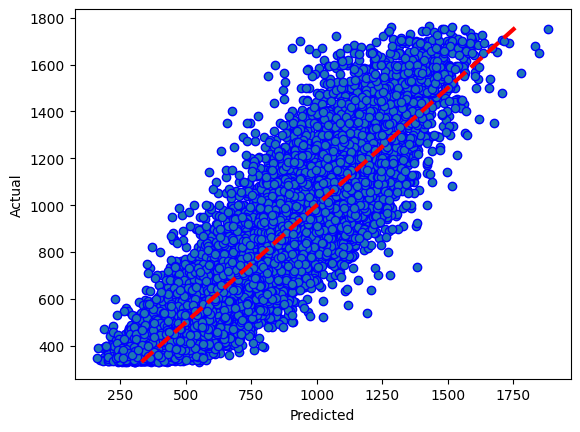

In [22]:
fig, ax = plt.subplots()
ax.scatter(y_pred,y_test,edgecolors=(0,0,1))
ax.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r--',
       lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [23]:
predict_df.head()

,totalRent,livingSpace,noRooms,rent_difference,additioncost,central_heating,combined_heat_and_power_plant,district_heating,floor_heating,gas_heating,heat_pump,night_storage_heater,oil_heating,self_contained_central_heating,wood_pellet_heating,Other,first_time_use,first_time_use_after_refurbishment,fully_renovated,mint_condition,modernized,refurbished,well_kept,apartment,ground_floor,half_basement,loft,maisonette,other,penthouse,raised_ground_floor,roof_storey,terraced_flat,Aachen,Anhalt_Bitterfeld,Augsburg,Bautzen,Berlin,Bielefeld,Bochum,Bonn,Braunschweig,Bremen,Bremerhaven,Burgenlandkreis,Chemnitz,Cottbus,Dessau_Roßlau,Dortmund,Dresden,Duisburg,Düsseldorf,Ennepe_Ruhr,Erfurt,Erzgebirgskreis,Essen,Esslingen,Frankfurt_am_Main,Gelsenkirchen,Gera,Gießen,Görlitz,Hagen,Halle_Saale,Hamburg,Hannover,Harz,Heilbronn,Herne,Hochtaunuskreis,Karlsruhe,Kassel,Kiel,Krefeld,Köln,Leipzig,Lörrach,Magdeburg,Main_Kinzig,Main_Taunus,Mainz,Mannheim,Meißen,Mettmann,Mittelsachsen,Märkischer,Mönchengladbach,Mülheim_an_der_Ruhr,München,Neuss_Rhein,Nordsachsen,Nürnberg,Oberhausen,Offenbach,Other,Pinneberg,Plauen,Recklinghausen,Regensburg,Rhein_Erft,Rhein_Neckar,Rhein_Sieg,Rheinisch_Bergischer,Rostock,Saalekreis,Schwerin,Stuttgart,Sächsische_Schweiz_Osterzgebirge,Unna,Vogtlandkreis,Wesel,Wiesbaden,Wuppertal,Zwickau
0,840.00,86.00,4.0,245.0,245.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,903.00,84.97,3.0,138.0,138.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,380.00,62.00,2.0,70.0,70.0,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,584.25,60.30,3.0,132.0,132.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

### Create the Predict Function by using Ridge Regression Model

In [24]:
from numpy import random

def model_predict_price(model, df):
    random_data = df.iloc[random.randint(df.shape[0]-1),:]

    heatingIndex = np.where(X.columns == random_data['heatingType'])[0][0]
    conIndex = np.where(X.columns == random_data['condition'])[0][0]
    flatTypeIndex = np.where(X.columns == random_data['typeOfFlat'])[0][0]
    regionIndex = np.where(X.columns == random_data['regio2'])[0][0]

    x = np.zeros(len(X.columns))
    x[0] = random_data['livingSpace']
    x[1] = random_data['noRooms']
    x[2] = random_data['additioncost']
  

    if heatingIndex >= 0:
        x[heatingIndex] = 1
    if conIndex >= 0:
        x[conIndex] = 1
    if flatTypeIndex >= 0:
        x[flatTypeIndex] = 1
    if regionIndex >= 0:
        x[regionIndex] = 1

    predict_price = model.predict([x])[0]
    print(f"Price from the dataframe: {random_data['totalRent']}\nPrice from prediction :{predict_price}")

    return  predict_price

In [25]:
predict_price = model_predict_price(ridge, df)
print(predict_price)

Price from the dataframe: 825.0
Price from prediction :779.1747868869443
779.1747868869443


## Create the function to compare randomly between the prediction and the dataset

In [26]:
def comparison(model, df):
    list_of_diff = [] # Create a list to calculate the average
    
    for i in range(0,20):
        random_data = df.iloc[random.randint(df.shape[0]-1),:]

        heatingIndex = np.where(X.columns == random_data['heatingType'])[0][0]
        conIndex = np.where(X.columns == random_data['condition'])[0][0]
        flatTypeIndex = np.where(X.columns == random_data['typeOfFlat'])[0][0]
        regionIndex = np.where(X.columns == random_data['regio2'])[0][0]

        x = np.zeros(len(X.columns))
        x[0] = random_data['livingSpace']
        x[1] = random_data['noRooms']
        x[2] = random_data['additioncost']
      

        if heatingIndex >= 0:
            x[heatingIndex] = 1
        if conIndex >= 0:
            x[conIndex] = 1
        if flatTypeIndex >= 0:
            x[flatTypeIndex] = 1
        if regionIndex >= 0:
            x[regionIndex] = 1

        predict_price = model.predict([x])[0]
        diff = abs(random_data['totalRent']-predict_price)
        print(f"{i:<5}: Dataframe: {random_data['totalRent']:<10},  Model Prediction : {round(predict_price,2):<10},  Difference: {round(diff,2)}")

        
        # add the number of difference value of train and test to the list
        list_of_diff.append(diff) 
        # print("\n======================\n")
    
    avg = sum(list_of_diff)/len(list_of_diff)
    print("\n======================")
    print(f"\nThe average of the difference from the actual and prediction: {avg}")

### Testing the data randomly by using comparison function

In [27]:
comparison(ridge, df)

0    : Dataframe: 1000.0    ,  Model Prediction : 728.61    ,  Difference: 271.39
1    : Dataframe: 506.0     ,  Model Prediction : 418.54    ,  Difference: 87.46
2    : Dataframe: 810.0     ,  Model Prediction : 756.14    ,  Difference: 53.86
3    : Dataframe: 1349.0    ,  Model Prediction : 905.93    ,  Difference: 443.07
4    : Dataframe: 415.0     ,  Model Prediction : 408.63    ,  Difference: 6.37
5    : Dataframe: 1020.0    ,  Model Prediction : 725.4     ,  Difference: 294.6
6    : Dataframe: 490.0     ,  Model Prediction : 321.86    ,  Difference: 168.14
7    : Dataframe: 604.12    ,  Model Prediction : 515.07    ,  Difference: 89.05
8    : Dataframe: 533.92    ,  Model Prediction : 498.79    ,  Difference: 35.13
9    : Dataframe: 525.0     ,  Model Prediction : 503.26    ,  Difference: 21.74
10   : Dataframe: 360.0     ,  Model Prediction : 256.18    ,  Difference: 103.82
11   : Dataframe: 428.69    ,  Model Prediction : 321.31    ,  Difference: 107.38
12   : Dataframe: 1617.0

## Light Gradient Boost

### Setting hyperparameters and fit the model

In [28]:
d_train = lgb.Dataset(x_train, label=y_train) # Load the dataset and test

# parameters for this model
params = {
        'n_estimators': 10000,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01,
        'subsample': 0.72,
        'subsample_freq': 4,
        'feature_fraction': 0.4,
        'lambda_l1': 1,
        'lambda_l2': 1,
        'seed': 46,
        }

lightgb = lgb.train(params, d_train, 100)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 160505, number of used features: 113
[LightGBM] [Info] Start training from score 716.423137


Check the data is what'we expected or not.

In [29]:
y_pred = lightgb.predict(x_test)
y_pred

array([ 414.02854367,  402.44242757,  706.10129178, ..., 1238.13192068,
        622.49476429,  398.07644483])

The result of the 'Light Gradient Boosting Machine' is working great and we could use this model in concern of accuracy if compare with the 'Ridge Regression'

In [30]:
lightgb_evaluation = evaluate_function(lightgb,x_test,y_test,'Light Gradient Boost')
lightgb_evaluation

Model name: Light Gradient Boost

Coefficient of Determination (R2 score) of the model: 0.85
RMSE (Root Mean Square Error) of the prediction: 117.658
MAE (Mean Absolute Error) of the prediction: 82.922


{'Model Name': 'Light Gradient Boost',
 'R2': 0.8499247822923556,
 'RMSE': 117.65783150190443,
 'MAE': 82.92206956666226}

### Testing the data randomly by using comparison function

In [31]:
comparison(lightgb, df)

0    : Dataframe: 665.0     ,  Model Prediction : 597.64    ,  Difference: 67.36
1    : Dataframe: 413.0     ,  Model Prediction : 393.24    ,  Difference: 19.76
2    : Dataframe: 748.54    ,  Model Prediction : 1005.99   ,  Difference: 257.45
3    : Dataframe: 1570.0    ,  Model Prediction : 1327.23   ,  Difference: 242.77
4    : Dataframe: 873.04    ,  Model Prediction : 727.75    ,  Difference: 145.29
5    : Dataframe: 650.0     ,  Model Prediction : 478.39    ,  Difference: 171.61
6    : Dataframe: 454.04    ,  Model Prediction : 450.95    ,  Difference: 3.09
7    : Dataframe: 800.0     ,  Model Prediction : 1021.71   ,  Difference: 221.71
8    : Dataframe: 350.0     ,  Model Prediction : 385.03    ,  Difference: 35.03
9    : Dataframe: 1150.0    ,  Model Prediction : 961.56    ,  Difference: 188.44
10   : Dataframe: 1260.0    ,  Model Prediction : 1278.5    ,  Difference: 18.5
11   : Dataframe: 984.0     ,  Model Prediction : 831.26    ,  Difference: 152.74
12   : Dataframe: 885.0

Let's try some rows to make sure our models is working properly

## Catboost

### Setting hyperparameters and fit the model

In [32]:
!pip3 install catboost
import catboost as cb

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

In [33]:
train_dataset = cb.Pool(x_train, y_train)
test_dataset = cb.Pool(x_test, y_test)

In [34]:
catboost = cb.CatBoostRegressor(loss_function="RMSE")

In [35]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
catboost.grid_search(grid, train_dataset)

0:	learn: 756.7390455	test: 759.4566228	best: 759.4566228 (0)	total: 61.1ms	remaining: 6.05s
1:	learn: 735.8875223	test: 738.6005593	best: 738.6005593 (1)	total: 64.2ms	remaining: 3.15s
2:	learn: 715.7325342	test: 718.4344684	best: 718.4344684 (2)	total: 66.7ms	remaining: 2.16s
3:	learn: 696.2078275	test: 698.9032266	best: 698.9032266 (3)	total: 70.1ms	remaining: 1.68s
4:	learn: 677.5133673	test: 680.2221178	best: 680.2221178 (4)	total: 73ms	remaining: 1.39s
5:	learn: 659.4598602	test: 662.1256528	best: 662.1256528 (5)	total: 75ms	remaining: 1.18s
6:	learn: 641.7478519	test: 644.3767719	best: 644.3767719 (6)	total: 77.3ms	remaining: 1.03s
7:	learn: 624.7233225	test: 627.3291625	best: 627.3291625 (7)	total: 80.5ms	remaining: 926ms
8:	learn: 608.2057319	test: 610.7892763	best: 610.7892763 (8)	total: 82.6ms	remaining: 835ms
9:	learn: 592.2798419	test: 594.8382930	best: 594.8382930 (9)	total: 85.5ms	remaining: 770ms
10:	learn: 576.7545564	test: 579.3119403	best: 579.3119403 (10)	total: 87.

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [36]:
y_preds = catboost.predict(x_test)
y_preds

array([ 449.42058914,  417.41717074,  700.48310696, ..., 1268.92132857,
        633.2402428 ,  401.48761954])

In [37]:
catboost_evaluation = evaluate_function(catboost,x_test,y_test,'CatBoost')


Model name: CatBoost

Coefficient of Determination (R2 score) of the model: 0.835
RMSE (Root Mean Square Error) of the prediction: 123.271
MAE (Mean Absolute Error) of the prediction: 88.567


In [38]:
comparison(catboost, df)

0    : Dataframe: 648.37    ,  Model Prediction : 619.17    ,  Difference: 29.2
1    : Dataframe: 559.0     ,  Model Prediction : 559.04    ,  Difference: 0.04
2    : Dataframe: 442.0     ,  Model Prediction : 456.52    ,  Difference: 14.52
3    : Dataframe: 488.61    ,  Model Prediction : 417.02    ,  Difference: 71.59
4    : Dataframe: 594.0     ,  Model Prediction : 636.05    ,  Difference: 42.05
5    : Dataframe: 999.0     ,  Model Prediction : 710.47    ,  Difference: 288.53
6    : Dataframe: 880.0     ,  Model Prediction : 911.81    ,  Difference: 31.81
7    : Dataframe: 1250.0    ,  Model Prediction : 1348.54   ,  Difference: 98.54
8    : Dataframe: 511.0     ,  Model Prediction : 525.61    ,  Difference: 14.61
9    : Dataframe: 930.0     ,  Model Prediction : 487.29    ,  Difference: 442.71
10   : Dataframe: 381.71    ,  Model Prediction : 441.47    ,  Difference: 59.76
11   : Dataframe: 730.0     ,  Model Prediction : 600.57    ,  Difference: 129.43
12   : Dataframe: 593.0    

## Xgboost

### Setting hyperparameters and fit the model

In [39]:
import xgboost
from xgboost import XGBRegressor

In [40]:
xgboost = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             random_state=123)
xgboost = xgboost.fit(x_train, y_train)

In [41]:
y_preds = xgboost.predict(x_test)
y_preds

array([ 434.79523,  403.45303,  717.2355 , ..., 1314.3068 ,  631.0116 ,
        408.66455], dtype=float32)

In [42]:
xgboost_evaluation = evaluate_function(xgboost,x_test,y_test,'Xgboost')

Model name: Xgboost

Coefficient of Determination (R2 score) of the model: 0.839
RMSE (Root Mean Square Error) of the prediction: 122.052
MAE (Mean Absolute Error) of the prediction: 86.996


In [43]:
comparison(xgboost, df)

0    : Dataframe: 956.0     ,  Model Prediction : 1007.3900146484375,  Difference: 51.39
1    : Dataframe: 690.0     ,  Model Prediction : 574.4600219726562,  Difference: 115.54
2    : Dataframe: 640.0     ,  Model Prediction : 583.47998046875,  Difference: 56.52
3    : Dataframe: 535.0     ,  Model Prediction : 641.489990234375,  Difference: 106.49
4    : Dataframe: 415.0     ,  Model Prediction : 470.69000244140625,  Difference: 55.69
5    : Dataframe: 517.5     ,  Model Prediction : 489.1400146484375,  Difference: 28.36
6    : Dataframe: 1231.0    ,  Model Prediction : 981.1799926757812,  Difference: 249.82
7    : Dataframe: 887.0     ,  Model Prediction : 832.1400146484375,  Difference: 54.86
8    : Dataframe: 772.0     ,  Model Prediction : 901.9500122070312,  Difference: 129.95
9    : Dataframe: 550.0     ,  Model Prediction : 495.70001220703125,  Difference: 54.3
10   : Dataframe: 720.0     ,  Model Prediction : 765.9600219726562,  Difference: 45.96
11   : Dataframe: 462.0     ,

## Linear Regression

### Setting hyperparameters and fit the model

In [44]:
from sklearn.linear_model import LinearRegression

In [46]:
linear = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1)
linear = linear.fit(x_train, y_train)

In [47]:
y_preds = linear.predict(x_test)
y_pred[0:100]

array([ 414.02854367,  402.44242757,  706.10129178,  760.50017903,
        520.36571794,  752.63816485,  902.64303397, 1274.4961721 ,
        462.75515203,  923.31503643,  628.25128673,  688.6386557 ,
        424.63218505,  630.96896076,  442.31052235, 1115.94303324,
       1207.04471126,  739.76974143,  456.07493176,  959.21645651,
       1023.50836513,  910.06921523,  446.08991379,  525.79661389,
       1168.00067308, 1259.51253817,  659.8731658 ,  953.27504951,
        485.06702557,  786.2609161 , 1009.72679842, 1028.56578902,
       1405.11325583,  452.40793192,  737.67213501, 1264.47651898,
        529.62132696,  557.80002869,  471.80134017, 1077.64414566,
        734.65736715,  518.34493131,  597.51216746,  979.0902031 ,
        659.90764803,  548.52512578,  467.17484013,  841.87518304,
        432.61222422,  925.99363865,  650.14420027,  887.05562238,
        574.68807847,  914.33395159, 1031.7263415 ,  509.57784674,
        546.55358783,  617.64411029,  815.66599571,  787.24711

In [48]:
linear_evaluation = evaluate_function(linear,x_test,y_test,'Linear Regression')

Model name: Linear Regression

Coefficient of Determination (R2 score) of the model: 0.817
RMSE (Root Mean Square Error) of the prediction: 129.797
MAE (Mean Absolute Error) of the prediction: 95.253


# Comparison between models

In [49]:
ridge_evaluation

{'Model Name': 'Ridge Regression',
 'R2': 0.817361568907661,
 'RMSE': 129.7963359148108,
 'MAE': 95.2484561219059}

In [50]:
# Create comparison dataframe from our past dictionary
comparison = pd.DataFrame({ridge_evaluation['Model Name']:ridge_evaluation,
                           lightgb_evaluation['Model Name']:lightgb_evaluation,
                           catboost_evaluation['Model Name']:catboost_evaluation,
                           xgboost_evaluation['Model Name']:xgboost_evaluation,
                           linear_evaluation['Model Name']:linear_evaluation})


comparison = comparison.transpose()
comparison.reset_index(drop=True)

,Model Name,R2,RMSE,MAE
0,Ridge Regression,0.817362,129.796336,95.248456
1,Light Gradient Boost,0.849925,117.657832,82.92207
2,CatBoost,0.835265,123.270646,88.566978
3,Xgboost,0.838507,122.051615,86.995763
4,Linear Regression,0.817361,129.796544,95.253411


## Accuracy of the model

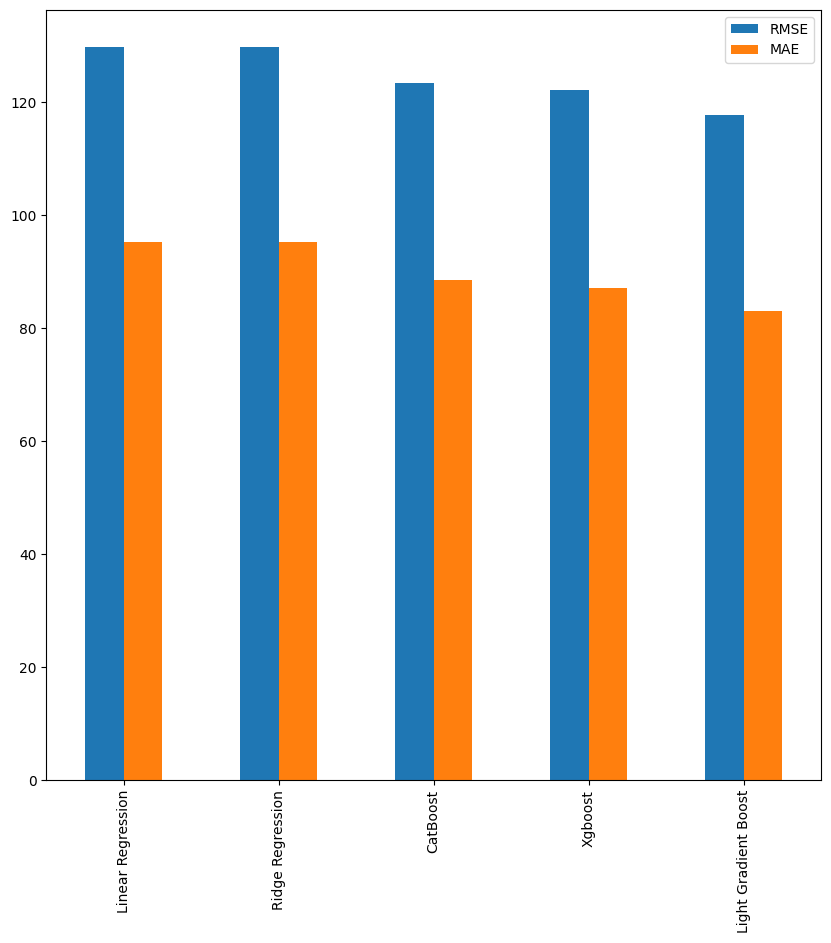

In [51]:
comparison[['RMSE','MAE']].sort_values('RMSE',ascending=False).plot(kind='bar',figsize=(10,10)).legend(bbox_to_anchor=(1.0,1.0))

## The speed/score tradeoff

### Create the function to measure the time of prediction

In [52]:
import time
def pred_timer(model,samples):
    start_time = time.perf_counter()
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time-start_time
    time_per_pred = total_time/len(samples)
    return total_time, time_per_pred

Calcuate the Ridge Regression time per prediction

In [53]:
x_test.shape

(17834, 113)

In [54]:
total_pred_time_ridge_reg, time_per_pred_ridge_reg = pred_timer(ridge,x_test)

print('Ridge Regression Model')
print(f"Total time prediction for test dataframe: {round(total_pred_time_ridge_reg,3)}")
print(f"Time per each prediction: {round(time_per_pred_ridge_reg,10)}")


Ridge Regression Model
Total time prediction for test dataframe: 0.047
Time per each prediction: 2.66e-06


Calculate the Light Gradient Boost time per prediction

In [55]:
total_pred_time_lgbm, time_per_pred_lgbm = pred_timer(lightgb,x_test)

print("Light Gradient Boost Model")
print(f"Total time prediction for test dataframe: {round(total_pred_time_lgbm,3)} seconds")
print(f"Time per each prediction: {round(time_per_pred_lgbm,10)}")


Light Gradient Boost Model
Total time prediction for test dataframe: 10.633 seconds
Time per each prediction: 0.0005962287


Calculate the CatBoost time per prediction

In [56]:
total_pred_time_catboost, time_per_pred_catboost = pred_timer(catboost,x_test)

print("Light Gradient Boost Model")
print(f"Total time prediction for test dataframe: {round(total_pred_time_catboost,3)} seconds")
print(f"Time per each prediction: {round(time_per_pred_catboost,10)}")


Light Gradient Boost Model
Total time prediction for test dataframe: 0.187 seconds
Time per each prediction: 1.04865e-05


Calculate the XgBoost time per prediction

In [57]:
total_pred_time_xgboost, time_per_pred_xgboost = pred_timer(xgboost,x_test)

print("Light Gradient Boost Model")
print(f"Total time prediction for test dataframe: {round(total_pred_time_xgboost,3)} seconds")
print(f"Time per each prediction: {round(time_per_pred_xgboost,10)}")


Light Gradient Boost Model
Total time prediction for test dataframe: 0.048 seconds
Time per each prediction: 2.6648e-06


Calculate the Linear Regression time per prediction

In [58]:
total_pred_time_linear, time_per_pred_linear = pred_timer(linear,x_test)

print("Linear Regression Model")
print(f"Total time prediction for test dataframe: {round(total_pred_time_linear,3)} seconds")
print(f"Time per each prediction: {round(time_per_pred_linear,10)}")


Linear Regression Model
Total time prediction for test dataframe: 0.045 seconds
Time per each prediction: 2.5177e-06


Text(0, 0.5, 'RMSE')

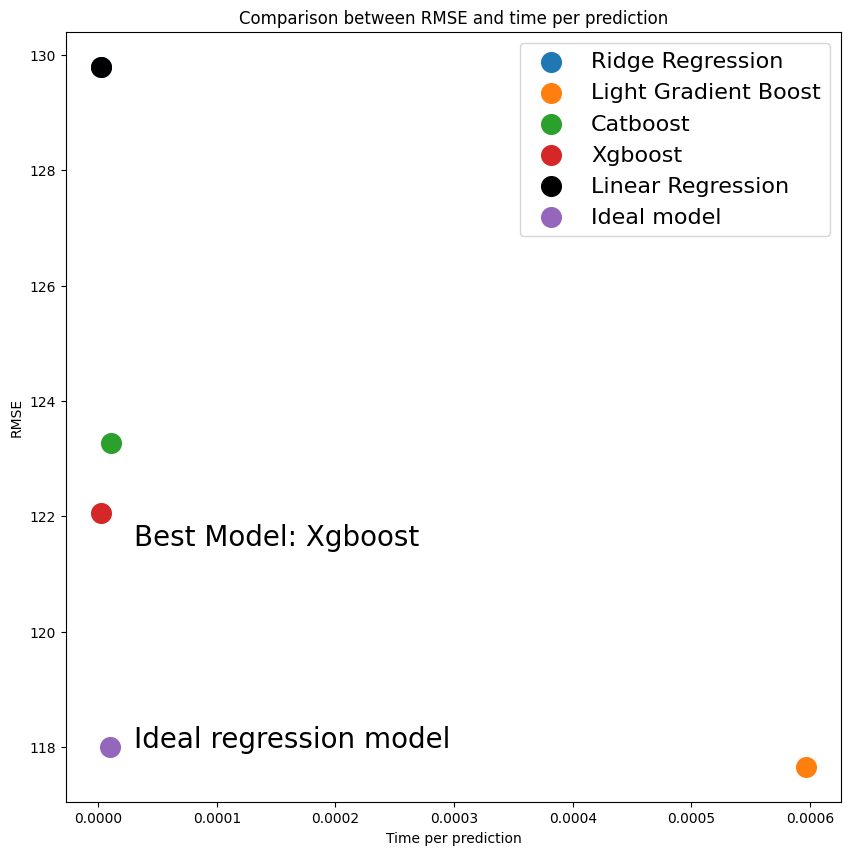

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
#plt.axis((-1, 15, 116, 132))
plt.scatter(time_per_pred_ridge_reg, ridge_evaluation['RMSE'], s=200, label="Ridge Regression")
plt.scatter(time_per_pred_lgbm, lightgb_evaluation['RMSE'], s=200,  label="Light Gradient Boost")
plt.scatter(time_per_pred_catboost, catboost_evaluation['RMSE'], s=200, label="Catboost")
plt.scatter(time_per_pred_xgboost, xgboost_evaluation['RMSE'], s=200, label="Xgboost")
plt.text(x=0.00003, y=121.5, s="Best Model: Xgboost", size=20)
plt.scatter(time_per_pred_linear, linear_evaluation['RMSE'], s=200, c="black", label="Linear Regression")
plt.scatter(0.00001,118, s=200, label="Ideal model")
plt.text(x=0.00003, y=118, s="Ideal regression model", size=20)

plt.legend(prop={'size': 16})
plt.title("Comparison between RMSE and time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("RMSE")

## Conclusion

\\From the plot above we could see that Xgboost Regressor might have slightly error compare to Light Gradient Boost Machine but the time is much faster. Then if you want the model that is has a better prediction 'Light Gradient Boost Machine' might be better answer. However, if you're concern of speed, 'Ridge Regression' has 10 times better in speed.

I would use 'Xgboost' to predict the price afterward due to the resources and the scope of my work is limited.

# Saving the model for further use.

In [71]:
import pickle
with open('german_home_prices_model.pickle','wb') as f:
    pickle.dump(xgboost,f)

In [72]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

# Summary

This is the end of the kernel, if you love this kernel or could study something from this please upvote! it means a lot for my future opportunity. Moreover, feel free to comment on my mistakes because it would be surely help me to improve my mistakes.

Thanks for viewing!